In [1]:
import deepSI
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from tqdm.auto import tqdm
from deepSI import System_data, System_data_list

## Data generation

Creating some data for the system

$$
x_{t+1} = a x_t + u_t\\
y_t = x_t
$$

with $a=0.5$

In [2]:
class my_sys(deepSI.System_ss): #a simple state-space wrapper of the general System class
    def __init__(self, a=0.5):
        super(my_sys, self).__init__(nx=1)
        self.a = a
    
    def f(self, x, u):
        return self.a*x + u
    
    def h(self,x,u):
        return x[0]

a_now = 0.5
sys = my_sys(a=a_now)
data = sys.sample_system(N_sampes=10000) #uniform -1,1 
train, test = data.train_test_split()
train, val = train.train_test_split()
print('train:\t', train)
print('val:\t', val)
print('test:\t', test)

train:	 System_data of length: 5625 nu=None ny=None normed=False dt=None
val:	 System_data of length: 1875 nu=None ny=None normed=False dt=None
test:	 System_data of length: 2500 nu=None ny=None normed=False dt=None


## Creating a custom encoder, $f_\theta$, $g_\theta$ for this sytem.

In [3]:
class my_encoder_net(nn.Module): #a simple FC net with a residual (defaulth appraoch)
    def __init__(self, nb, nu, na, ny, nx, n_nodes_per_layer=64, n_hidden_layers=2, activation=nn.Tanh):
        super(my_encoder_net, self).__init__()
        from deepSI.utils import simple_res_net
        self.nu = tuple() if nu is None else ((nu,) if isinstance(nu,int) else nu)
        self.ny = tuple() if ny is None else ((ny,) if isinstance(ny,int) else ny)
        self.net = simple_res_net(n_in=nb*np.prod(self.nu,dtype=int) + na*np.prod(self.ny,dtype=int), \
            n_out=nx, n_nodes_per_layer=n_nodes_per_layer, n_hidden_layers=n_hidden_layers, activation=activation)

    def forward(self, upast, ypast):
        net_in = torch.cat([upast.view(upast.shape[0],-1),ypast.view(ypast.shape[0],-1)],axis=1)
        return self.net(net_in)

class my_lin_encoder_net(nn.Module): #linear encoder appraoch
    def __init__(self, nb, nu, na, ny, nx, b0=0.5):
        super(my_lin_encoder_net, self).__init__()
        self.b = nn.Parameter(data=torch.as_tensor(b0))

    def forward(self, upast, ypast):
        #first dimention is always the batch dimension (Nb)
        #upast shape: (Nb, nb)
        #ypast shape: (Nb, na)
        return (upast[:,-1] + self.b*ypast[:,-1])[:,None]

class my_state_net(nn.Module): #
    def __init__(self, nx, nu, a0=0.5):
        super(my_state_net, self).__init__()
        self.a = nn.Parameter(data=torch.as_tensor(a0))

    def forward(self, x, u):
        #first dimention is always the batch dimention
        # x shape: (Nb, 1)
        # u shape: (Nb)
        return x*self.a + u[:,None]

class my_output_net(nn.Module):
    def __init__(self, nx, ny):
        super(my_output_net, self).__init__()

    def forward(self, x, u=None):
        #first dimention is always the batch dimention
        return x[:,0] #(Nb,nx)

## test if this setup can reproduce the data

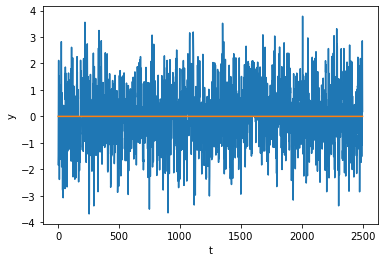

3.1389216516923886e-08

In [4]:

fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, na=1, nb=1, \
                                                e_net=my_lin_encoder_net, e_net_kwargs=dict(b0=a_now),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now),\
                                                h_net=my_output_net)
fit_sys.init_model(nu=None, ny=None) #init the network callaed as e_net(**e_net_kwargs) 
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
test_p.NRMS(test) #3.2e-8

# Fitting with linear encoder

In [5]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, e_net=my_lin_encoder_net, e_net_kwargs=dict(b0=a_now*0.9),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now*0.9),\
                                                h_net=my_output_net)
fit_sys.init_model(nu=None,ny=None)
fit_sys.fit(train,val, epochs=100, loss_kwargs=dict(nf=25), auto_fit_norm=False, optimizer_kwargs=dict(betas=(0.99,0.999))) #nf = T in the paper


Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  2.9 MB
N_training_samples = 5581, batch_size = 256, N_batch_updates_per_epoch = 21
Initial Validation sim-NRMS= 0.07007669915812052


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.04237204267695391
Epoch    1, sqrt loss 0.06308, Val sim-NRMS 0.04237, Time Loss: 60.3%, data: 3.8%, val: 35.9%, 123.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.018828062131723576
Epoch    2, sqrt loss 0.03449, Val sim-NRMS 0.01883, Time Loss: 55.8%, data: 2.6%, val: 41.6%, 148.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.0045102974963951254
Epoch    3, sqrt loss  0.0131, Val sim-NRMS 0.00451, Time Loss: 53.0%, data: 2.9%, val: 44.1%, 158.3 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.0004869272207263055
Epoch    4, sqrt loss 0.00235, Val sim-NRMS 0.0004869, Time Loss: 51.5%, data: 3.4%, val: 45.1%, 163.9 batches/sec
Epoch    5, sqrt loss 0.0008511, Val sim-NRMS 0.0006931, Time Loss: 51.2%, data: 3.0%, val: 45.8%, 167.9 batches/sec
########## New lowest validation loss achieved ########### sim-N

Epoch   63, sqrt loss 4.204e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.8%, data: 3.2%, val: 48.8%, 182.8 batches/sec
Epoch   64, sqrt loss 4.202e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.8%, data: 3.2%, val: 48.8%, 182.8 batches/sec
Epoch   65, sqrt loss 4.206e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.7%, data: 3.2%, val: 48.8%, 182.9 batches/sec
Epoch   66, sqrt loss 4.212e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.8%, data: 3.2%, val: 48.8%, 183.0 batches/sec
Epoch   67, sqrt loss 4.199e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.4%, data: 3.9%, val: 48.5%, 181.6 batches/sec
Epoch   68, sqrt loss 4.213e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.4%, data: 3.9%, val: 48.5%, 181.7 batches/sec
Epoch   69, sqrt loss 4.214e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.4%, data: 3.9%, val: 48.5%, 181.8 batches/sec
Epoch   70, sqrt loss 4.211e-08, Val sim-NRMS 3.275e-08, Time Loss: 47.4%, data: 3.9%, val: 48.5%, 181.9 batches/sec
Epoch   71, sqrt loss 4.211e-08, Val sim-NRMS 3.275e-08, Time Lo

### Results

a fitted: 0.5  real a: 0.5
b fitted: 0.4999999701976776  real b: 0.5


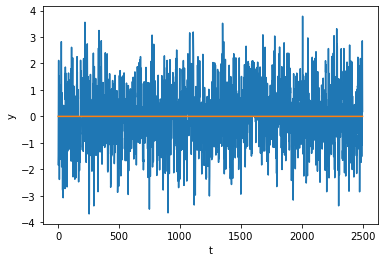

NRMS= 3.1423845272688305e-08


In [6]:
print('a fitted:', fit_sys.fn.a.item(), ' real a:',a_now)
print('b fitted:', fit_sys.encoder.b.item(), ' real b:',a_now)
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
print('NRMS=',test_p.NRMS(test)) #1.0e-7

# Nonlinear encoder

In [7]:
fit_sys = deepSI.fit_systems.SS_encoder_general(nx=1, na=2, nb=2,\
                                                e_net=my_encoder_net, e_net_kwargs=dict(),\
                                                f_net=my_state_net, f_net_kwargs=dict(a0=a_now*0.9),\
                                                h_net=my_output_net)
fit_sys.init_model(nu=None,ny=None)
fit_sys.fit(train, val, epochs=100, loss_kwargs=dict(nf=25), auto_fit_norm=False, optimizer_kwargs=dict(betas=(0.99,0.999))) #nf = T in the paper


Model already initilized (init_model_done=True), skipping initilizing of the model, the norm and the creation of the optimizer
Size of the training array =  1.7 MB
N_training_samples = 5599, batch_size = 256, N_batch_updates_per_epoch = 21
Initial Validation sim-NRMS= 0.09902142478713301


  0%|          | 0/100 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.04365238507031458
Epoch    1, sqrt loss  0.2406, Val sim-NRMS 0.04365, Time Loss: 52.5%, data: 3.8%, val: 43.7%, 146.7 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.01877681140834024
Epoch    2, sqrt loss  0.0734, Val sim-NRMS 0.01878, Time Loss: 53.4%, data: 3.1%, val: 43.5%, 153.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.005284886420754603
Epoch    3, sqrt loss  0.0546, Val sim-NRMS 0.005285, Time Loss: 53.0%, data: 2.8%, val: 44.1%, 156.8 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.0007578687232293115
Epoch    4, sqrt loss 0.04919, Val sim-NRMS 0.0007579, Time Loss: 52.7%, data: 3.0%, val: 44.3%, 159.2 batches/sec
Epoch    5, sqrt loss 0.04717, Val sim-NRMS 0.0009883, Time Loss: 52.9%, data: 3.1%, val: 44.1%, 160.3 batches/sec
Epoch    6, sqrt loss 0.04536, Val sim-NRMS 0.0009422, Time Loss: 5

Epoch   65, sqrt loss 0.004302, Val sim-NRMS 0.0007622, Time Loss: 54.2%, data: 2.3%, val: 43.3%, 161.8 batches/sec
Epoch   66, sqrt loss 0.004362, Val sim-NRMS 0.0005823, Time Loss: 54.2%, data: 2.3%, val: 43.3%, 161.9 batches/sec
Epoch   67, sqrt loss 0.004355, Val sim-NRMS 0.0008125, Time Loss: 54.2%, data: 2.3%, val: 43.3%, 162.0 batches/sec
Epoch   68, sqrt loss 0.004374, Val sim-NRMS 0.001093, Time Loss: 54.2%, data: 2.3%, val: 43.3%, 162.1 batches/sec
Epoch   69, sqrt loss 0.004316, Val sim-NRMS 0.0009505, Time Loss: 54.2%, data: 2.3%, val: 43.4%, 162.1 batches/sec
Epoch   70, sqrt loss 0.004132, Val sim-NRMS 0.0008635, Time Loss: 54.2%, data: 2.3%, val: 43.4%, 162.2 batches/sec
Epoch   71, sqrt loss 0.004178, Val sim-NRMS 0.0007358, Time Loss: 54.2%, data: 2.3%, val: 43.4%, 162.3 batches/sec
Epoch   72, sqrt loss 0.004106, Val sim-NRMS 0.0007221, Time Loss: 54.2%, data: 2.3%, val: 43.4%, 162.4 batches/sec
Epoch   73, sqrt loss 0.004024, Val sim-NRMS 0.0006856, Time Loss: 54.2%,

## Results nonlinear encoder

a fitted: 0.5000396370887756  real a: 0.5


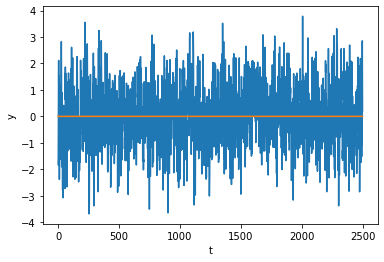

NRMS: 0.00018599538128569616


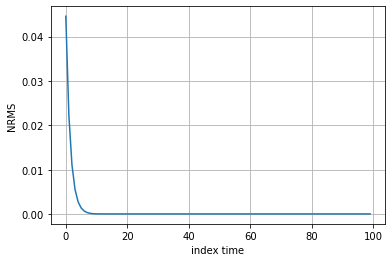

In [8]:
print('a fitted:', fit_sys.fn.a.item(), ' real a:',a_now)
test_p = fit_sys.apply_experiment(test)
test.plot()
(test_p-test).plot()
plt.show()
print('NRMS:',test_p.NRMS(test)) #1.0e-7
fit_sys.n_step_error_plot(test) #encoder isn't perfect but it works